title: Matching Studies - Roundup 

author: Jiawei Wang

date: 2023-01-16

region: EU

link: https://docs.google.com/presentation/d/1y6n5Pgr7f-P6xL7t9SuA4_ClKFJYgDzwgItAq_iQOHQ/edit#slide=id.g1ca2c5884b2_0_87

tags: roundup, matching, NC1, KNN, LogisticRegression, propensity score, linear regression, causal inference

summary: This is the research for understanding the incremental NC1 a premium user brings by using roundup feature. It looks into premium users(choose a premium tier from KYCC) from Jan- May 2022. The studies compares the difference of users NC1 in 6 months between two groups: the users who ever used Roundup vs the users who never used Roundup. There are 4 different types of statistical/ML methods involved.  

research_type:  user profitability, growth insights, features

### Table Prepping

In [1]:
import utils
import numpy as np
import pandas as pd

In [10]:
user = pd.read_csv("jw_roundup_matching_0105.csv")

In [4]:
rev1 = pd.read_csv("roundup_matching_rev1_clean.csv")

In [5]:
rev2 = pd.read_csv("roundup_matching_rev2_1_clean.csv")

In [6]:
rev3 = pd.read_csv("roundup_matching_rev2_2_clean.csv")

In [12]:
tot_rev1 = pd.concat([rev1, rev2], ignore_index=True)

In [13]:
tot_rev2 = pd.concat([tot_rev1, rev3], ignore_index=True)

In [14]:
tot_rev2["month"] = tot_rev2["month"].astype(str)
tot_rev2["month"] = tot_rev2["month"].str.strip()

In [15]:
user_rev_all = user.merge(
    tot_rev2,
    how="left",
    left_on=["user_created", "rev_mos"],
    right_on=["user_created", "month"],
)

In [17]:
user_rev_all = user_rev_all.drop(["rest"], axis=1)

### Table Cleaning

In [18]:
user_rev_all.describe()

,mos_to_kycc,round_up,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,net_rev1
count,21432.000000,21432.000000,21420.000000,21420.000000,21420.000000,21420.000000,21432.000000,19196.000000
mean,7.904255,0.170726,3.000420,22.840430,156.302206,982.072879,304.376200,12.700583
std,1.371220,0.376278,3.693173,21.599905,869.854906,2656.219973,1421.604624,30.279749
min,6.000000,0.000000,0.000000,0.000000,0.000000,4.083862,-1571.790000,-1092.720000
25%,7.000000,0.000000,1.000000,6.000000,32.894295,212.993150,2.008125,4.490000
50%,8.000000,0.000000,2.000000,17.000000,57.220701,465.607599,29.542321,8.450000
75%,9.000000,0.000000,4.000000,33.000000,113.095388,1003.723289,170.034375,15.150000
max,10.000000,1.000000,89.000000,409.000000,66174.792857,174396.256667,89242.643333,920.410000


In [20]:
pd.isnull(user_rev_all).sum()

user_created            0
mos_to_kycc             0
country_tnc_legal       0
tier                    0
rev_mos                 0
round_up                0
n_in                   12
n_out                  12
avg_out_amount         12
avg_in_amount          12
pri_balance             0
month                2236
net_rev1             2236
dtype: int64

In [21]:
# Dropping entries without revenue info

df = user_rev_all.dropna(subset=["net_rev1"], how="all")

In [22]:
df = df.drop(columns=["rev_mos", "month"])

In [23]:
# fill the missing values with 0
df = df.fillna(0)

In [24]:
pd.isnull(df).sum()

user_created         0
mos_to_kycc          0
country_tnc_legal    0
tier                 0
round_up             0
n_in                 0
n_out                0
avg_out_amount       0
avg_in_amount        0
pri_balance          0
net_rev1             0
dtype: int64

In [26]:
# Cleaning outliners in NC1 data
len(df[(df["net_rev1"] >= 50)])

800

In [27]:
# Cleaning outliners in NC1 data
len(df[(df["net_rev1"] <= -20)])

344

In [28]:
df.loc[df["net_rev1"] <= -20, "net_rev1"] = -20

In [29]:
df.loc[df["net_rev1"] >= 50, "net_rev1"] = 50

<AxesSubplot:>

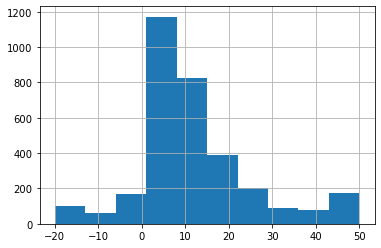

In [30]:
df.query("round_up==1")["net_rev1"].hist()

<AxesSubplot:>

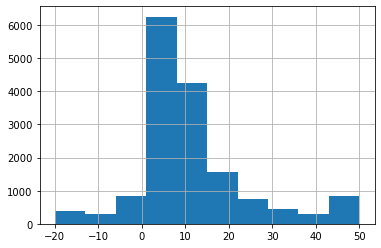

In [31]:
df.query("round_up==0")["net_rev1"].hist()

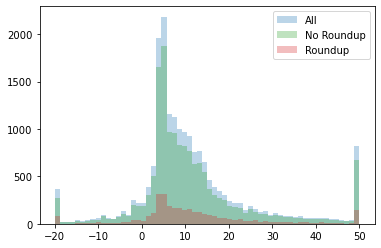

In [33]:
import matplotlib.pyplot as plt

plt.hist(df["net_rev1"], bins=60, alpha=0.3, label="All")
plt.hist(
    df.query("round_up==0")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="No Roundup",
    color="C2",
)
plt.hist(
    df.query("round_up==1")["net_rev1"], bins=60, alpha=0.3, label="Roundup", color="C3"
)
plt.legend();

In [34]:
df.groupby(["country_tnc_legal"])["net_rev1"].describe()

,count,mean,std,min,25%,50%,75%,max
country_tnc_legal,,,,,,,,
AUT,814.0,13.064914,14.045878,-20.0,4.84,9.59,17.605,50.0
DEU,9297.0,11.854130,13.743351,-20.0,4.53,8.32,15.720,50.0
ESP,1677.0,10.791777,12.977608,-20.0,4.18,8.02,14.750,50.0
FRA,7408.0,11.104993,12.719815,-20.0,4.48,8.49,14.470,50.0


In [35]:
df.groupby(["tier"])["net_rev1"].describe()

,count,mean,std,min,25%,50%,75%,max
tier,,,,,,,,
METAL,4421.0,17.469778,15.775637,-20.0,10.45,14.320,24.13,50.0
SMART,11607.0,8.835686,11.531942,-20.0,3.90,5.470,11.17,50.0
YOU,3168.0,13.073419,12.700158,-20.0,7.18,9.465,16.20,50.0


In [36]:
df.groupby(["tier", "country_tnc_legal"])["net_rev1"].describe()

count       mean        std   min      25%     50%  \
tier  country_tnc_legal                                                        
METAL AUT                 203.0  17.701970  17.029112 -20.0  11.0000  14.550   
      DEU                1553.0  18.594231  16.699535 -20.0  10.4900  14.900   
      ESP                 375.0  15.857787  14.819085 -20.0  10.4050  13.640   
      FRA                2290.0  16.950603  15.114514 -20.0  10.4500  13.995   
SMART AUT                 489.0  10.142434  11.737596 -20.0   4.2300   6.030   
      DEU                6293.0   9.723517  12.312778 -20.0   4.0300   6.120   
      ESP                 991.0   8.338910  11.682680 -20.0   3.6350   5.030   
      FRA                3834.0   7.340170   9.859023 -20.0   3.7500   4.920   
YOU   AUT                 122.0  17.063033  14.110547 -20.0   8.7925  11.910   
      DEU                1451.0  13.880717  13.494302 -20.0   7.2950  10.260   
      ESP                 311.0  12.499293  12.511058 -20.0   6.9600   9.120   
      FRA                1284.0  11.921106  11.492939 -20.0   7.0375   8.960   

                             75%   max  
tier  country_tnc_legal                 
METAL AUT                25.7500  50.0  
      DEU                26.3400  50.0  
      ESP                21.5150  50.0  
      FRA                22.7375  50.0  
SMART AUT                12.0000  50.0  
      DEU                12.3300  50.0  
      ESP                11.0150  50.0  
      FRA                 9.1375  50.0  
YOU   AUT                21.1725  50.0  
      DEU                17.5950  50.0  
      ESP                15.1650  50.0  
      FRA                13.8800  50.0

In [37]:
df_metal = df.loc[df["tier"] == "METAL"]
df_smart = df.loc[df["tier"] == "SMART"]
df_you = df.loc[df["tier"] == "YOU"]

In [38]:
len(df_metal) + len(df_smart) + len(df_you)

19196

### Naive comparison

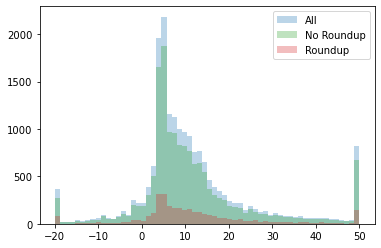

In [39]:
plt.hist(df["net_rev1"], bins=60, alpha=0.3, label="All")
plt.hist(
    df.query("round_up==0")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="No Roundup",
    color="C2",
)
plt.hist(
    df.query("round_up==1")["net_rev1"], bins=60, alpha=0.3, label="Roundup", color="C3"
)
plt.legend();

In [40]:
# ALL
df.query("round_up==1")["net_rev1"].mean() - df.query("round_up==0")["net_rev1"].mean()

0.4159605790978347

In [41]:
# separate control and treatment for t-test
df_control = df[df.round_up == 0]
df_treatment = df[df.round_up == 1]

In [43]:
from scipy.stats import ttest_ind

print(df_control.net_rev1.mean(), df_treatment.net_rev1.mean())

# compare samples
_, p = ttest_ind(df_control.net_rev1, df_treatment.net_rev1)
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

11.453028668214012 11.868989247311847
p=0.104
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


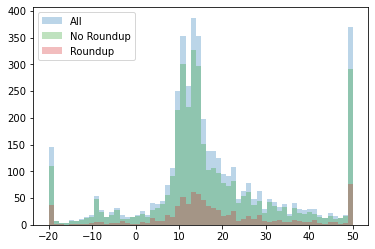

In [44]:
plt.hist(df_metal["net_rev1"], bins=60, alpha=0.3, label="All")
plt.hist(
    df_metal.query("round_up==0")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="No Roundup",
    color="C2",
)
plt.hist(
    df_metal.query("round_up==1")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="Roundup",
    color="C3",
)
plt.legend();

In [45]:
# Metal
(
    df_metal.query("round_up==1")["net_rev1"].mean()
    - df_metal.query("round_up==0")["net_rev1"].mean()
)

1.0876026663906515

In [46]:
# separate control and treatment for t-test
df_metal_control = df_metal[df_metal.round_up == 0]
df_metal_treatment = df_metal[df_metal.round_up == 1]

In [47]:
from scipy.stats import ttest_ind

print(df_metal_control.net_rev1.mean(), df_metal_treatment.net_rev1.mean())

# compare samples
_, p = ttest_ind(df_metal_control.net_rev1, df_metal_treatment.net_rev1)
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

17.264361405465646 18.351964071856298
p=0.073
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


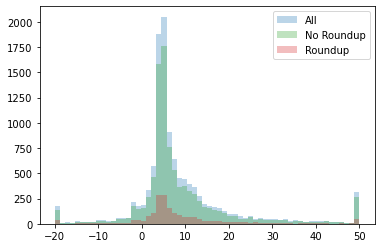

In [48]:
plt.hist(df_smart["net_rev1"], bins=60, alpha=0.3, label="All")
plt.hist(
    df_smart.query("round_up==0")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="No Roundup",
    color="C2",
)
plt.hist(
    df_smart.query("round_up==1")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="Roundup",
    color="C3",
)
plt.legend();

In [49]:
# Smart
(
    df_smart.query("round_up==1")["net_rev1"].mean()
    - df_smart.query("round_up==0")["net_rev1"].mean()
)

-0.11623994708546448

In [50]:
# separate control and treatment for t-test
df_smart_control = df_smart[df_smart.round_up == 0]
df_smart_treatment = df_smart[df_smart.round_up == 1]

In [51]:
print(df_smart_control.net_rev1.mean(), df_smart_treatment.net_rev1.mean())

# compare samples
_, p = ttest_ind(df_smart_control.net_rev1, df_smart_treatment.net_rev1)
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

8.854844233546524 8.73860428646106
p=0.687
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


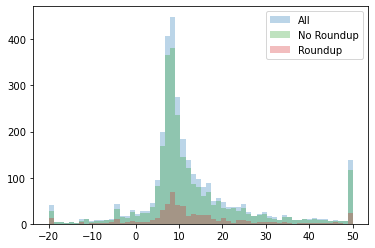

In [52]:
plt.hist(df_you["net_rev1"], bins=60, alpha=0.3, label="All")
plt.hist(
    df_you.query("round_up==0")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="No Roundup",
    color="C2",
)
plt.hist(
    df_you.query("round_up==1")["net_rev1"],
    bins=60,
    alpha=0.3,
    label="Roundup",
    color="C3",
)
plt.legend();

In [53]:
# You
(
    df_you.query("round_up==1")["net_rev1"].mean()
    - df_you.query("round_up==0")["net_rev1"].mean()
)

-0.08336811137866995

In [54]:
# separate control and treatment for t-test
df_you_control = df_you[df_you.round_up == 0]
df_you_treatment = df_you[df_you.round_up == 1]

In [55]:
print(df_you_control.net_rev1.mean(), df_you_treatment.net_rev1.mean())

# compare samples
_, p = ttest_ind(df_you_control.net_rev1, df_you_treatment.net_rev1)
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

13.086760616309634 13.003392504930964
p=0.892
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


### Model Preperation

In [56]:
categ = ["country_tnc_legal"]
num = ["mos_to_kycc", "n_in", "n_out", "avg_out_amount", "avg_in_amount", "pri_balance"]

df_cat_metal = pd.get_dummies(df_metal[categ], columns=categ, drop_first=True)

print(df_cat_metal.shape)

(4421, 3)


In [57]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

df_num_metal = StandardScaler().fit_transform(df_metal[num].values)

In [58]:
df_num_metal = pd.DataFrame(df_num_metal, index=df_metal.index, columns=num)

In [59]:
final_metal = pd.concat([df_num_metal, df_cat_metal], axis=1)

In [60]:
tbl_ty_metal = df_metal[["round_up", "net_rev1"]].set_index(df_metal.index)

In [61]:
metal_tbl = pd.concat([final_metal, tbl_ty_metal], axis=1)

In [62]:
metal_tbl

,mos_to_kycc,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,country_tnc_legal_DEU,country_tnc_legal_ESP,country_tnc_legal_FRA,round_up,net_rev1
5,-1.357572,-0.574118,-1.023237,-0.120268,-0.452025,-0.162198,0,0,1,0,13.49
6,0.079131,-0.819257,-0.903232,-0.102527,-0.317199,-0.161895,0,1,0,1,10.07
11,-1.357572,0.161301,-0.823229,0.318958,-0.146467,-0.078745,1,0,0,0,10.81
14,0.079131,-0.328978,-0.143204,-0.006319,0.177559,-0.159428,0,0,1,1,16.94
15,0.797482,-0.819257,-1.023237,-0.030378,-0.239511,-0.153397,1,0,0,0,10.25
...,...,...,...,...,...,...,...,...,...,...,...
21406,0.079131,-0.574118,-0.583220,-0.102197,-0.188218,-0.153912,0,0,1,0,13.56
21410,1.515833,-0.083839,-0.463216,-0.117433,-0.405333,-0.162228,0,0,1,0,8.13
21415,-1.357572,-0.819257,-1.063238,-0.147070,-0.389021,-0.162319,0,0,1,0,10.45
21424,1.515833,-0.574118,0.096805,-0.106794,0.000718,-0.161865,0,1,0,1,15.87


In [79]:
df_cat_smart = pd.get_dummies(df_smart[categ], columns=categ, drop_first=True)

print(df_cat_smart.shape)

(11607, 3)


In [80]:
df_num_smart = StandardScaler().fit_transform(df_smart[num].values)

In [81]:
df_num_smart = pd.DataFrame(df_num_smart, index=df_smart.index, columns=num)

In [82]:
final_smart = pd.concat([df_num_smart, df_cat_smart], axis=1)

In [83]:
tbl_ty_smart = df_smart[["round_up", "net_rev1"]].set_index(df_smart.index)

In [84]:
smart_tbl = pd.concat([final_smart, tbl_ty_smart], axis=1)

In [95]:
df_cat_you = pd.get_dummies(df_you[categ], columns=categ, drop_first=True)

print(df_cat_you.shape)

(3168, 3)


In [96]:
df_num_you = StandardScaler().fit_transform(df_you[num].values)

In [97]:
df_num_you = pd.DataFrame(df_num_you, index=df_you.index, columns=num)

In [98]:
final_you = pd.concat([df_num_you, df_cat_you], axis=1)

In [99]:
tbl_ty_you = df_you[["round_up", "net_rev1"]].set_index(df_you.index)

In [100]:
you_tbl = pd.concat([final_you, tbl_ty_you], axis=1)

### Metal Matching

In [63]:
# Using logistic regression to predict the likelihood a user would use Roundup feature

from sklearn.linear_model import LogisticRegression

T = "round_up"
Y = "net_rev1"
X = metal_tbl.columns.drop([T, Y])

ps_model = LogisticRegression().fit(metal_tbl[X], metal_tbl[T])

metal_ps = metal_tbl.assign(propensity_score=ps_model.predict_proba(metal_tbl[X])[:, 1])

metal_ps[["round_up", "net_rev1", "propensity_score"]].head()

,round_up,net_rev1,propensity_score
5,0,13.49,0.134462
6,1,10.07,0.126491
11,0,10.81,0.081187
14,1,16.94,0.128226
15,0,10.25,0.146021


In [64]:
metal_ps_final = metal_ps[["round_up", "net_rev1", "propensity_score"]]

In [65]:
# ols estimation - Regressing NC1 with the propensity score and Roundup boolean, focusing on the coefficient of round_up

import statsmodels.formula.api as smf

smf.ols(
    "net_rev1 ~ round_up + propensity_score", data=metal_ps_final
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.5690,0.507,34.676,0.000,16.576,18.562
round_up,1.2034,0.628,1.916,0.055,-0.028,2.435
propensity_score,-1.7288,2.456,-0.704,0.482,-6.544,3.086


/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/3799280746.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(metal_ps_final.query("round_up==0")["propensity_score"], kde=False, label="No Roundup")
/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/3799280746.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/d

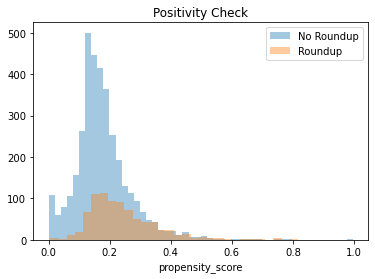

In [66]:
# Plotting the propensity score distribution to make sure there's big enough overlapped between the two groups

import seaborn as sns

sns.distplot(
    metal_ps_final.query("round_up==0")["propensity_score"],
    kde=False,
    label="No Roundup",
)
sns.distplot(
    metal_ps_final.query("round_up==1")["propensity_score"], kde=False, label="Roundup"
)
plt.title("Positivity Check")
plt.legend();

In [67]:
# Using the Python package based on the propensity score method to directly get the ATE

from causalinference import CausalModel

cm = CausalModel(
    Y=metal_ps_final["net_rev1"].values,
    D=metal_ps_final["round_up"].values,
    X=metal_ps_final[["propensity_score"]].values,
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.602      1.252      1.280      0.200     -0.851      4.056
           ATC      1.786      1.399      1.277      0.202     -0.955      4.527
           ATT      0.814      1.228      0.663      0.508     -1.593      3.220



/Users/jiaweiwang/opt/anaconda3/lib/python3.9/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [68]:
print(cm.summary_stats)


Summary Statistics

                      Controls (N_c=3586)         Treated (N_t=835)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       17.264       15.618       18.352       16.416        1.088

                      Controls (N_c=3586)         Treated (N_t=835)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.176        0.092        0.243        0.113        0.648



In [74]:
columns = metal_tbl.columns[:-2]

In [75]:
# Mannually matching the two groups to each other with KNN

from sklearn.neighbors import KNeighborsRegressor

roundup = metal_tbl.query("round_up==1")
non_roundup = metal_tbl.query("round_up==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(
    non_roundup[columns], non_roundup["net_rev1"]
)
mt1 = KNeighborsRegressor(n_neighbors=1).fit(roundup[columns], roundup["net_rev1"])

predicted = pd.concat(
    [
        # find matches for the treated looking at the untreated knn model
        roundup.assign(match=mt0.predict(roundup[columns])),
        # find matches for the untreated looking at the treated knn model
        non_roundup.assign(match=mt1.predict(non_roundup[columns])),
    ]
)

In [76]:
# Using regression for bias correction

from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(non_roundup[columns], non_roundup["net_rev1"])
ols1 = LinearRegression().fit(roundup[columns], roundup["net_rev1"])

# find the units that match to the treated
roundup_match_index = mt0.kneighbors(roundup[columns], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
non_roundup_match_index = mt1.kneighbors(non_roundup[columns], n_neighbors=1)[1].ravel()

In [77]:
predicted = pd.concat(
    [
        (
            roundup
            # find the Y match on the other group
            .assign(match=mt0.predict(roundup[columns])).assign(
                bias_correct=ols0.predict(roundup[columns])
                - ols0.predict(non_roundup.iloc[roundup_match_index][columns])
            )
        ),
        (
            non_roundup.assign(match=mt1.predict(non_roundup[columns])).assign(
                bias_correct=ols1.predict(non_roundup[columns])
                - ols1.predict(roundup.iloc[non_roundup_match_index][columns])
            )
        ),
    ]
)

predicted.head()

,mos_to_kycc,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,country_tnc_legal_DEU,country_tnc_legal_ESP,country_tnc_legal_FRA,round_up,net_rev1,match,bias_correct
6,0.079131,-0.819257,-0.903232,-0.102527,-0.317199,-0.161895,0,1,0,1,10.07,10.45,-0.142617
14,0.079131,-0.328978,-0.143204,-0.006319,0.177559,-0.159428,0,0,1,1,16.94,30.98,-0.360650
20,1.515833,0.896719,-0.543219,-0.123084,-0.446948,-0.162290,0,0,1,1,22.47,47.93,0.350984
38,1.515833,-0.328978,0.896835,-0.103806,0.057078,-0.155327,0,0,1,1,16.52,16.09,-0.018554
55,1.515833,0.161301,0.376816,-0.093587,-0.249542,-0.154236,1,0,0,1,9.58,10.73,-0.339025


In [78]:
# Mannually calculating the ATE

np.mean(
    (2 * predicted["round_up"] - 1)
    * ((predicted["net_rev1"] - predicted["match"]) - predicted["bias_correct"])
)

1.6143473098039702

In [90]:
print(cm_smart.summary_stats)


Summary Statistics

                      Controls (N_c=9694)        Treated (N_t=1913)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        8.855       11.561        8.739       11.385       -0.116

                      Controls (N_c=9694)        Treated (N_t=1913)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.153        0.093        0.223        0.107        0.696



In [91]:
from sklearn.neighbors import KNeighborsRegressor

roundup = smart_tbl.query("round_up==1")
non_roundup = smart_tbl.query("round_up==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(
    non_roundup[columns], non_roundup["net_rev1"]
)
mt1 = KNeighborsRegressor(n_neighbors=1).fit(roundup[columns], roundup["net_rev1"])

predicted = pd.concat(
    [
        # find matches for the treated looking at the untreated knn model
        roundup.assign(match=mt0.predict(roundup[columns])),
        # find matches for the untreated looking at the treated knn model
        non_roundup.assign(match=mt1.predict(non_roundup[columns])),
    ]
)

In [92]:
# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(non_roundup[columns], non_roundup["net_rev1"])
ols1 = LinearRegression().fit(roundup[columns], roundup["net_rev1"])

# find the units that match to the treated
roundup_match_index = mt0.kneighbors(roundup[columns], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
non_roundup_match_index = mt1.kneighbors(non_roundup[columns], n_neighbors=1)[1].ravel()

In [93]:
predicted = pd.concat(
    [
        (
            roundup
            # find the Y match on the other group
            .assign(match=mt0.predict(roundup[columns])).assign(
                bias_correct=ols0.predict(roundup[columns])
                - ols0.predict(non_roundup.iloc[roundup_match_index][columns])
            )
        ),
        (
            non_roundup.assign(match=mt1.predict(non_roundup[columns])).assign(
                bias_correct=ols1.predict(non_roundup[columns])
                - ols1.predict(roundup.iloc[non_roundup_match_index][columns])
            )
        ),
    ]
)

predicted.head()

,mos_to_kycc,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,country_tnc_legal_DEU,country_tnc_legal_ESP,country_tnc_legal_FRA,round_up,net_rev1,match,bias_correct
8,1.549120,-0.259249,1.286953,-0.158031,-0.079191,-0.219320,1,0,0,1,3.74,2.38,0.056867
39,0.082032,0.816968,-0.400448,0.018307,-0.149785,-0.259500,1,0,0,1,-20.00,6.09,0.238567
45,1.549120,0.009805,0.691400,-0.130187,-0.167416,-0.246386,0,0,1,1,13.81,3.78,-0.031833
50,0.082032,0.816968,0.492882,-0.060527,-0.107377,-0.238405,1,0,0,1,19.93,3.10,-0.395223
68,-1.385057,0.009805,1.138065,-0.099723,0.195882,1.142560,1,0,0,1,-9.96,13.39,0.128910


In [94]:
np.mean(
    (2 * predicted["round_up"] - 1)
    * ((predicted["net_rev1"] - predicted["match"]) - predicted["bias_correct"])
)

0.8195844347206687

In [139]:
cm = CausalModel(
    Y=smart_tbl["net_rev1"].values,
    D=smart_tbl["round_up"].values,
    X=smart_tbl[columns].values,
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.838      0.544      1.540      0.124     -0.228      1.904
           ATC      0.998      0.596      1.674      0.094     -0.171      2.167
           ATT      0.024      0.555      0.043      0.965     -1.064      1.112



### You Matching

In [101]:
ps_model = LogisticRegression().fit(you_tbl[X], you_tbl[T])

you_ps = you_tbl.assign(propensity_score=ps_model.predict_proba(you_tbl[X])[:, 1])

you_ps[["round_up", "net_rev1", "propensity_score"]].head()

,round_up,net_rev1,propensity_score
3,0,14.68,0.009024
7,0,8.55,0.140581
23,0,8.83,0.101332
26,0,5.86,0.085411
35,0,6.57,0.140629


In [102]:
you_ps_final = you_ps[["round_up", "net_rev1", "propensity_score"]]

In [103]:
smf.ols(
    "net_rev1 ~ round_up + propensity_score", data=you_ps_final
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,13.0150,0.426,30.580,0.000,12.181,13.850
round_up,-0.1193,0.640,-0.186,0.852,-1.374,1.135
propensity_score,0.4842,2.343,0.207,0.836,-4.109,5.078


/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/1823628384.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(you_ps_final.query("round_up==0")["propensity_score"], kde=False, label="No Roundup")
/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/1823628384.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

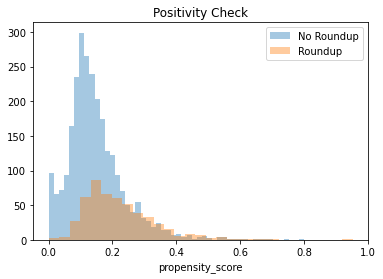

In [104]:
import seaborn as sns

sns.distplot(
    you_ps_final.query("round_up==0")["propensity_score"], kde=False, label="No Roundup"
)
sns.distplot(
    you_ps_final.query("round_up==1")["propensity_score"], kde=False, label="Roundup"
)
plt.title("Positivity Check")
plt.legend();

In [105]:
cm_you = CausalModel(
    Y=you_ps_final["net_rev1"].values,
    D=you_ps_final["round_up"].values,
    X=you_ps_final[["propensity_score"]].values,
)

cm_you.est_via_matching(matches=1, bias_adj=True)

print(cm_you.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.758      1.422      0.533      0.594     -2.030      3.546
           ATC      1.002      1.582      0.633      0.527     -2.099      4.103
           ATT     -0.526      1.270     -0.414      0.679     -3.014      1.963



/Users/jiaweiwang/opt/anaconda3/lib/python3.9/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [106]:
print(cm_you.summary_stats)


Summary Statistics

                      Controls (N_c=2661)         Treated (N_t=507)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       13.087       12.622       13.003       13.113       -0.083

                      Controls (N_c=2661)         Treated (N_t=507)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.148        0.093        0.222        0.113        0.717



In [107]:
from sklearn.neighbors import KNeighborsRegressor

roundup = you_tbl.query("round_up==1")
non_roundup = you_tbl.query("round_up==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(
    non_roundup[columns], non_roundup["net_rev1"]
)
mt1 = KNeighborsRegressor(n_neighbors=1).fit(roundup[columns], roundup["net_rev1"])

predicted = pd.concat(
    [
        # find matches for the treated looking at the untreated knn model
        roundup.assign(match=mt0.predict(roundup[columns])),
        # find matches for the untreated looking at the treated knn model
        non_roundup.assign(match=mt1.predict(non_roundup[columns])),
    ]
)

In [108]:
# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(non_roundup[columns], non_roundup["net_rev1"])
ols1 = LinearRegression().fit(roundup[columns], roundup["net_rev1"])

# find the units that match to the treated
roundup_match_index = mt0.kneighbors(roundup[columns], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
non_roundup_match_index = mt1.kneighbors(non_roundup[columns], n_neighbors=1)[1].ravel()

In [109]:
predicted = pd.concat(
    [
        (
            roundup
            # find the Y match on the other group
            .assign(match=mt0.predict(roundup[columns])).assign(
                bias_correct=ols0.predict(roundup[columns])
                - ols0.predict(non_roundup.iloc[roundup_match_index][columns])
            )
        ),
        (
            non_roundup.assign(match=mt1.predict(non_roundup[columns])).assign(
                bias_correct=ols1.predict(non_roundup[columns])
                - ols1.predict(roundup.iloc[non_roundup_match_index][columns])
            )
        ),
    ]
)

predicted.head()

,mos_to_kycc,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,country_tnc_legal_DEU,country_tnc_legal_ESP,country_tnc_legal_FRA,round_up,net_rev1,match,bias_correct
37,-0.716012,-0.224448,0.555604,-0.144452,-0.116009,-0.181683,0,1,0,1,7.89,1.28,-1.047986
70,0.018312,-0.224448,0.744153,-0.146254,-0.049688,-0.073114,1,0,0,1,9.48,5.61,0.060819
74,0.018312,0.417005,0.697015,-0.108219,-0.148590,-0.229827,1,0,0,1,18.03,5.53,-0.425917
113,1.486959,0.096279,-0.528553,0.060090,-0.119642,-0.232537,1,0,0,1,6.76,10.55,-0.646384
128,0.752635,-0.865901,-1.094200,-0.118206,-0.262570,-0.219324,0,0,1,1,8.16,6.92,0.117891


In [110]:
np.mean(
    (2 * predicted["round_up"] - 1)
    * ((predicted["net_rev1"] - predicted["match"]) - predicted["bias_correct"])
)

-0.025440755227265327

In [138]:
cm = CausalModel(
    Y=you_tbl["net_rev1"].values,
    D=you_tbl["round_up"].values,
    X=you_tbl[columns].values,
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.643      1.153      0.558      0.577     -1.617      2.903
           ATC      0.511      1.232      0.414      0.679     -1.905      2.926
           ATT      1.338      1.439      0.930      0.352     -1.482      4.158



### All Tiers

In [111]:
df_cat = pd.get_dummies(df[categ], columns=categ, drop_first=True)

print(df_cat.shape)

(19196, 3)


In [112]:
df_num = StandardScaler().fit_transform(df[num].values)

In [113]:
df_num = pd.DataFrame(df_num, index=df.index, columns=num)

In [114]:
final_df = pd.concat([df_num, df_cat], axis=1)

In [115]:
tbl_ty = df[["round_up", "net_rev1"]].set_index(df.index)

In [116]:
final_tbl = pd.concat([final_df, tbl_ty], axis=1)

In [117]:
T = "round_up"
Y = "net_rev1"
X = final_tbl.columns.drop([T, Y])

ps_model = LogisticRegression().fit(final_tbl[X], final_tbl[T])

df_ps = final_tbl.assign(propensity_score=ps_model.predict_proba(final_tbl[X])[:, 1])

df_ps[["round_up", "net_rev1", "propensity_score"]].head()

,round_up,net_rev1,propensity_score
0,0,3.48,0.142868
1,0,4.55,0.114939
2,0,4.89,0.121954
3,0,14.68,0.017482
5,0,13.49,0.120449


In [118]:
df_ps_final = df_ps[["round_up", "net_rev1", "propensity_score"]]

In [119]:
smf.ols(
    "net_rev1 ~ round_up + propensity_score", data=df_ps_final
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.8462,0.191,62.147,0.000,11.473,12.220
round_up,0.5879,0.265,2.216,0.027,0.068,1.108
propensity_score,-2.4907,1.006,-2.476,0.013,-4.462,-0.519


/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/678845822.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ps_final.query("round_up==0")["propensity_score"], kde=False, label="No Roundup")
/var/folders/7n/yvwjwy5j0lg95vsn724zd9mh0000gp/T/ipykernel_32260/678845822.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

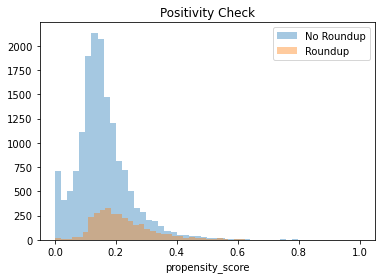

In [120]:
import seaborn as sns

sns.distplot(
    df_ps_final.query("round_up==0")["propensity_score"], kde=False, label="No Roundup"
)
sns.distplot(
    df_ps_final.query("round_up==1")["propensity_score"], kde=False, label="Roundup"
)
plt.title("Positivity Check")
plt.legend();

In [121]:
cm = CausalModel(
    Y=df_ps_final["net_rev1"].values,
    D=df_ps_final["round_up"].values,
    X=df_ps_final[["propensity_score"]].values,
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)

/Users/jiaweiwang/opt/anaconda3/lib/python3.9/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.970      0.566      1.714      0.087     -0.139      2.080
           ATC      1.155      0.630      1.833      0.067     -0.080      2.391
           ATT      0.065      0.525      0.123      0.902     -0.965      1.094



In [122]:
print(cm.summary_stats)


Summary Statistics

                     Controls (N_c=15941)        Treated (N_t=3255)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       11.453       13.224       11.869       13.737        0.416

                     Controls (N_c=15941)        Treated (N_t=3255)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.158        0.092        0.227        0.109        0.682



In [123]:
from sklearn.neighbors import KNeighborsRegressor

roundup = final_tbl.query("round_up==1")
non_roundup = final_tbl.query("round_up==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(
    non_roundup[columns], non_roundup["net_rev1"]
)
mt1 = KNeighborsRegressor(n_neighbors=1).fit(roundup[columns], roundup["net_rev1"])

predicted = pd.concat(
    [
        # find matches for the treated looking at the untreated knn model
        roundup.assign(match=mt0.predict(roundup[columns])),
        # find matches for the untreated looking at the treated knn model
        non_roundup.assign(match=mt1.predict(non_roundup[columns])),
    ]
)

In [124]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(non_roundup[columns], non_roundup["net_rev1"])
ols1 = LinearRegression().fit(roundup[columns], roundup["net_rev1"])

# find the units that match to the treated
roundup_match_index = mt0.kneighbors(roundup[columns], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
non_roundup_match_index = mt1.kneighbors(non_roundup[columns], n_neighbors=1)[1].ravel()

In [125]:
predicted = pd.concat(
    [
        (
            roundup
            # find the Y match on the other group
            .assign(match=mt0.predict(roundup[columns])).assign(
                bias_correct=ols0.predict(roundup[columns])
                - ols0.predict(non_roundup.iloc[roundup_match_index][columns])
            )
        ),
        (
            non_roundup.assign(match=mt1.predict(non_roundup[columns])).assign(
                bias_correct=ols1.predict(non_roundup[columns])
                - ols1.predict(roundup.iloc[non_roundup_match_index][columns])
            )
        ),
    ]
)

predicted.head()

,mos_to_kycc,n_in,n_out,avg_out_amount,avg_in_amount,pri_balance,country_tnc_legal_DEU,country_tnc_legal_ESP,country_tnc_legal_FRA,round_up,net_rev1,match,bias_correct
6,0.070875,-0.808565,-0.870617,-0.116923,-0.228116,-0.212807,0,1,0,1,10.07,4.47,0.063110
8,1.530647,-0.270810,1.114674,-0.149547,-0.108067,-0.180236,1,0,0,1,3.74,47.18,0.256787
14,0.070875,-0.270810,0.006605,0.003242,0.207467,-0.209282,0,0,1,1,16.94,8.38,-0.175248
20,1.530647,1.073577,-0.455091,-0.142598,-0.342347,-0.213371,0,0,1,1,22.47,7.06,-0.095760
37,-0.659012,-0.270810,0.606809,-0.128031,-0.100815,-0.156628,0,1,0,1,7.89,32.65,0.203807


In [126]:
np.mean(
    (2 * predicted["round_up"] - 1)
    * ((predicted["net_rev1"] - predicted["match"]) - predicted["bias_correct"])
)

1.1455690775204292

In [137]:
cm = CausalModel(
    Y=final_tbl["net_rev1"].values,
    D=final_tbl["round_up"].values,
    X=final_tbl[columns].values,
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)

/Users/jiaweiwang/opt/anaconda3/lib/python3.9/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.987      0.494      2.000      0.045      0.020      1.955
           ATC      1.104      0.543      2.032      0.042      0.039      2.169
           ATT      0.415      0.493      0.842      0.400     -0.551      1.382



### Result summary can be found in the link 